In [31]:
## Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, GRU, Bidirectional

import yfinance as yf
import seaborn as sns
import math



## Load data

In [2]:
msft_ticker = yf.Ticker("MSFT")
msft_data = msft_ticker.history(start="2000-01-01", end="2023-11-05", interval="1d")


In [3]:
msft_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.457984,36.846248,34.788449,36.205612,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.273772,36.380324,34.866095,34.982574,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.516662,36.147370,33.973092,35.351429,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.846687,35.370843,33.662482,34.167225,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.740119,34.866084,33.332442,34.613712,62013600,0.0,0.0


In [4]:
# check null
msft_data.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [71]:
msft_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5999.000000,5999.000000,5999.000000,5999.000000,5.999000e+03,5999.000000,5999.000000
mean,70.269762,70.999662,69.526129,70.286945,5.137814e+07,0.004432,0.000333
std,87.598423,88.504588,86.658379,87.619441,3.076160e+07,0.056597,0.025822
min,11.364952,11.678984,11.118213,11.327567,7.425600e+06,0.000000,0.000000
25%,19.032043,19.240168,18.869620,19.058251,2.875525e+07,0.000000,0.000000
50%,23.654439,23.861629,23.420220,23.640194,4.612340e+07,0.000000,0.000000
75%,78.026054,78.478431,77.442796,78.063660,6.507830e+07,0.000000,0.000000
max,360.985725,366.005075,351.695397,358.730469,5.910522e+08,3.080000,2.000000


## Data Visualization

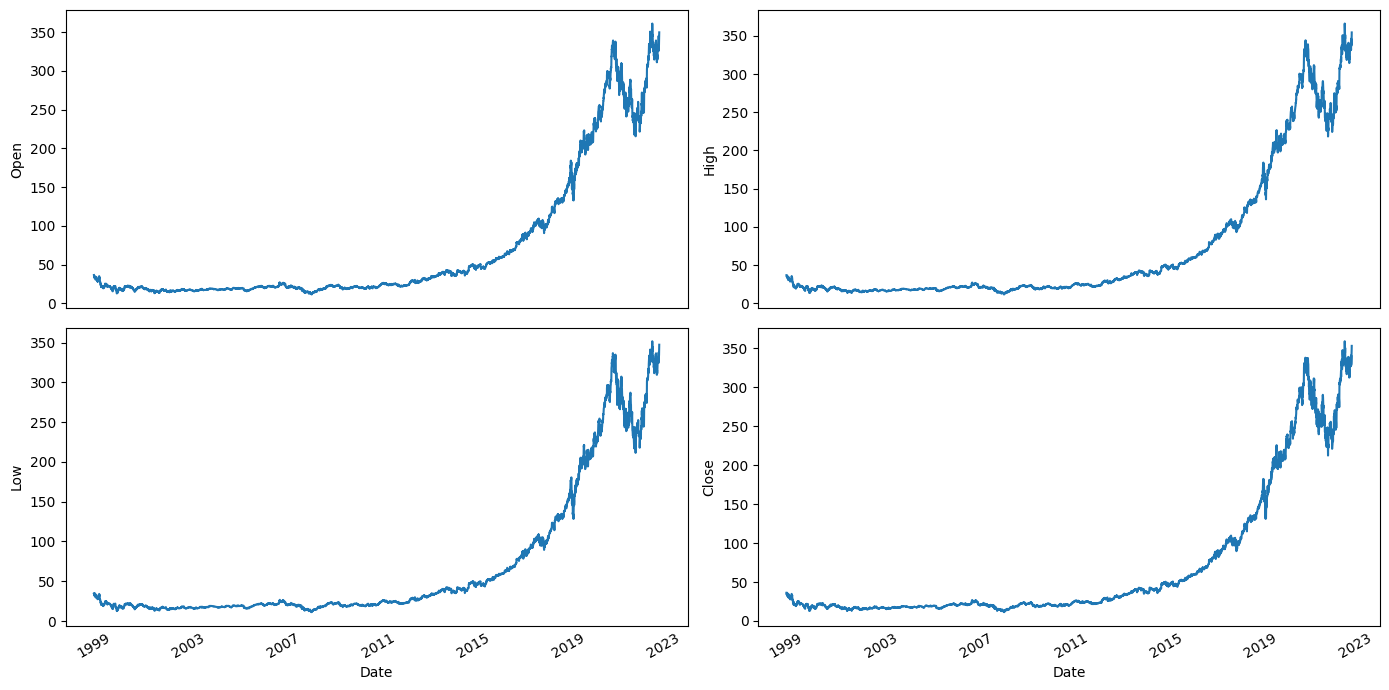

In [5]:
# Plot line charts
df_plot = msft_data[['Open','High','Low','Close']].copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [117]:
msft_close = msft_data[['Close']].copy()

scaler = MinMaxScaler()
msft_close_scaled = pd.DataFrame(scaler.fit_transform(msft_close)).rename(columns={0:"Close"})

msft_close_scaled.index = msft_close.index


In [118]:
# msft_close_scaled.head()
msft_close_scaled.head()

,Close
Date,
2000-01-03 00:00:00-05:00,0.071612
2000-01-04 00:00:00-05:00,0.068091
2000-01-05 00:00:00-05:00,0.069153
2000-01-06 00:00:00-05:00,0.065744
2000-01-07 00:00:00-05:00,0.067029


In [120]:

training_size = round((msft_close_scaled.shape[0]*0.1)*8)
validation_size = round((msft_close_scaled.shape[0]*0.1)*9)
test_size = round((msft_close_scaled.shape[0]))
print(training_size,validation_size-training_size,test_size-validation_size)

4799 600 600


Split Data

In [126]:
data_training = msft_close_scaled[:training_size]
data_validation = msft_close_scaled[training_size:validation_size]
data_test = msft_close_scaled[validation_size:test_size]

In [127]:
print(data_training.shape[0], data_validation.shape[0], data_test.shape[0])

4799 600 600


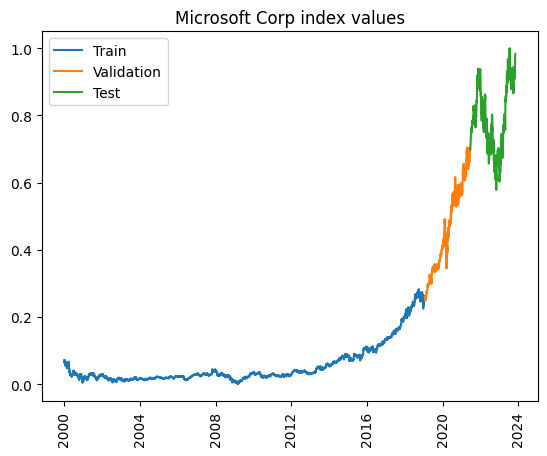

In [128]:
plt.plot(data_training.index, data_training)
plt.plot(data_validation.index, data_validation)
plt.plot(data_test.index, data_test)
plt.title("Microsoft Corp index values")
plt.xticks(rotation=90)
plt.legend(['Train', 'Validation', 'Test'])

In [77]:
TIME_STEP = 20
def create_sequence(data, time_step):

    sliding_data = []

    for index in range(len(data) - time_step):
        sliding_data.append(data[index: index + time_step])

    sliding_data = np.array(sliding_data)

    x_data = sliding_data.reshape(-1,time_step, 1)
    y_data = np.array(data[time_step:]).reshape(-1,1)

    return x_data, y_data

In [129]:
X_train, y_train = create_sequence(data_training, TIME_STEP)
X_val, y_val = create_sequence(data_validation, TIME_STEP)
X_test, y_test = create_sequence(data_test, TIME_STEP)

In [168]:
def plot_training_history(fitted_model):
    epochs = len(fitted_model.history['loss'])
    plt.plot(range(1,epochs+1), fitted_model.history['loss'], 'g', range(1,epochs+1), fitted_model.history['val_loss'], 'r')
    plt.legend(['training loss','validation loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

def plot_result(y_train, y_test, train_predict, test_predict):
    
    figure, axes = plt.subplots(figsize=(15, 6))
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    axes.plot(msft_close[TIME_STEP:validation_size-TIME_STEP].index, actual, color = 'red', label = 'Real Microsoft Corp Index Price ')
    axes.plot(msft_close[TIME_STEP:validation_size-TIME_STEP].index, predictions, color = 'blue', label = 'Predicted Microsoft Corp Index Price ')   
    plt.axvline(x = msft_close.index[training_size+TIME_STEP], color = 'g', label = 'training data cutoff')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title('Actual and Predicted Values')
    plt.show()

def print_error(y, predict, name):
    
    # Unscale the predicted values
    y_pred = scaler.inverse_transform(predict)
    y_unscaled = scaler.inverse_transform(y.reshape(-1, 1))
    
    # Root mean squared error (RMSE)
    RMSE = mean_squared_error(y_unscaled, y_pred, squared=False)
    print(f'{name} root mean squared error (RMSE): {np.round(RMSE, 3)}')
    return y_unscaled, y_pred
          


In [26]:
EPOCHS_NUM = 50
BATCH_SIZE = 32

###  Vanilla RNN

In [101]:
def vanilla_RNN(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


In [16]:
n_hidden_units = 64
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [130]:
# Create vanilla RNN model
vanilla_rnn = vanilla_RNN(n_hidden_units, n_dense_units, input_shape, activation='tanh')

# Training the vanilla RNN

fitted_vanilla_rnn = vanilla_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
150/150 [==============================] - 4s 9ms/step - loss: 4.0826e-04 - val_loss: 0.0133
Epoch 2/50
150/150 [==============================] - 1s 6ms/step - loss: 2.1665e-05 - val_loss: 0.0094
Epoch 3/50
150/150 [==============================] - 1s 6ms/step - loss: 1.4683e-05 - val_loss: 0.0076
Epoch 4/50
150/150 [==============================] - 1s 8ms/step - loss: 9.9261e-06 - val_loss: 0.0058
Epoch 5/50
150/150 [==============================] - 1s 6ms/step - loss: 8.4381e-06 - val_loss: 0.0038
Epoch 6/50
150/150 [==============================] - 1s 6ms/step - loss: 8.2082e-06 - val_loss: 0.0040
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 8.2597e-06 - val_loss: 0.0031
Epoch 8/50
150/150 [==============================] - 2s 10ms/step - loss: 6.7386e-06 - val_loss: 0.0035
Epoch 9/50
150/150 [==============================] - 1s 7ms/step - loss: 6.4726e-06 - val_loss: 0.0025
Epoch 10/50
150/150 [==============================] - 1s 7ms/s

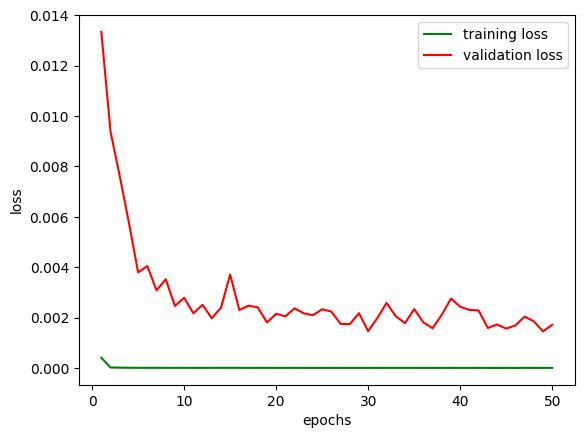

In [131]:
plot_training_history(fitted_vanilla_rnn)

In [150]:
train_predict_vanilla = fitted_vanilla_rnn.model.predict(X_train)
val_predict_vanilla = fitted_vanilla_rnn.model.predict(X_val)


19/19 [==============================] - 0s 7ms/step


In [156]:
y_train_unscaled, train_predict_vanilla_unscaled = print_error(y_train,train_predict_vanilla,'Train')
y_val_unscaled, val_predict_vanilla_unscaled = print_error(y_val,val_predict_vanilla,'Validation')

Train root mean squared error (RMSE): 0.671
Validation root mean squared error (RMSE): 14.389


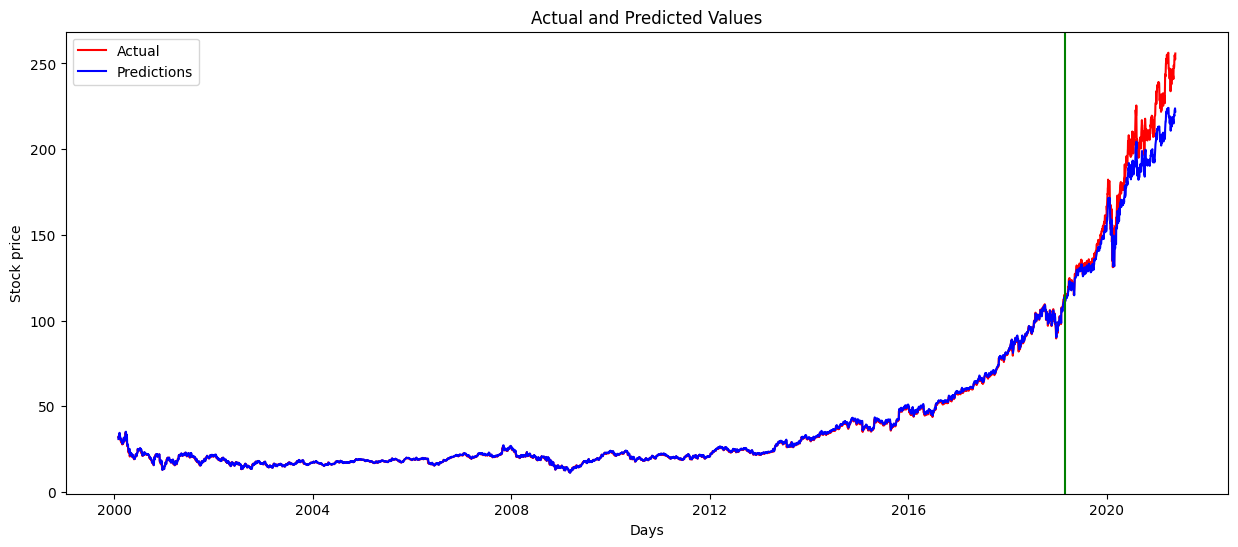

In [154]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_vanilla_unscaled, val_predict_vanilla_unscaled)

### Add more layers

In [157]:
# Creating RNN with multiple layers
def RNN_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units_list[0], input_shape=input_shape,activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [158]:
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [160]:
rnn_1 = RNN_1(n_hidden_units_list, n_dense_units,input_shape, activation='tanh')

fitted_rnn_1 = rnn_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
150/150 [==============================] - 8s 22ms/step - loss: 0.0052 - val_loss: 0.0213
Epoch 2/50
150/150 [==============================] - 2s 15ms/step - loss: 3.5826e-05 - val_loss: 0.0155
Epoch 3/50
150/150 [==============================] - 3s 19ms/step - loss: 2.3761e-05 - val_loss: 0.0123
Epoch 4/50
150/150 [==============================] - 2s 15ms/step - loss: 1.9696e-05 - val_loss: 0.0120
Epoch 5/50
150/150 [==============================] - 3s 19ms/step - loss: 1.9377e-05 - val_loss: 0.0106
Epoch 6/50
150/150 [==============================] - 2s 16ms/step - loss: 1.5433e-05 - val_loss: 0.0088
Epoch 7/50
150/150 [==============================] - 3s 17ms/step - loss: 2.5687e-05 - val_loss: 0.0074
Epoch 8/50
150/150 [==============================] - 2s 15ms/step - loss: 4.1841e-05 - val_loss: 0.0081
Epoch 9/50
150/150 [==============================] - 3s 18ms/step - loss: 2.4878e-05 - val_loss: 0.0064
Epoch 10/50
150/150 [==============================] - 2s 1

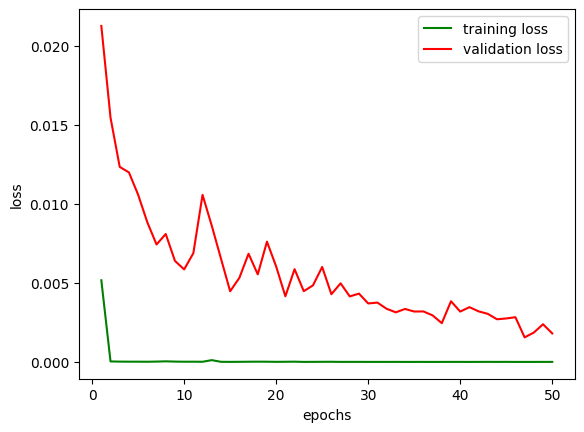

In [161]:
plot_training_history(fitted_rnn_1)

In [162]:
train_predict_rnn1 = fitted_rnn_1.model.predict(X_train)
val_predict_rnn1 = fitted_rnn_1.model.predict(X_val)


19/19 [==============================] - 0s 7ms/step


In [164]:
y_train_unscaled, train_predict_rnn1_unscaled = print_error(y_train,train_predict_rnn1,'Train')
y_val_unscaled, val_predict_rnn1_unscaled = print_error(y_val,val_predict_rnn1,'Validation')

Train root mean squared error (RMSE): 0.64
Validation root mean squared error (RMSE): 14.777


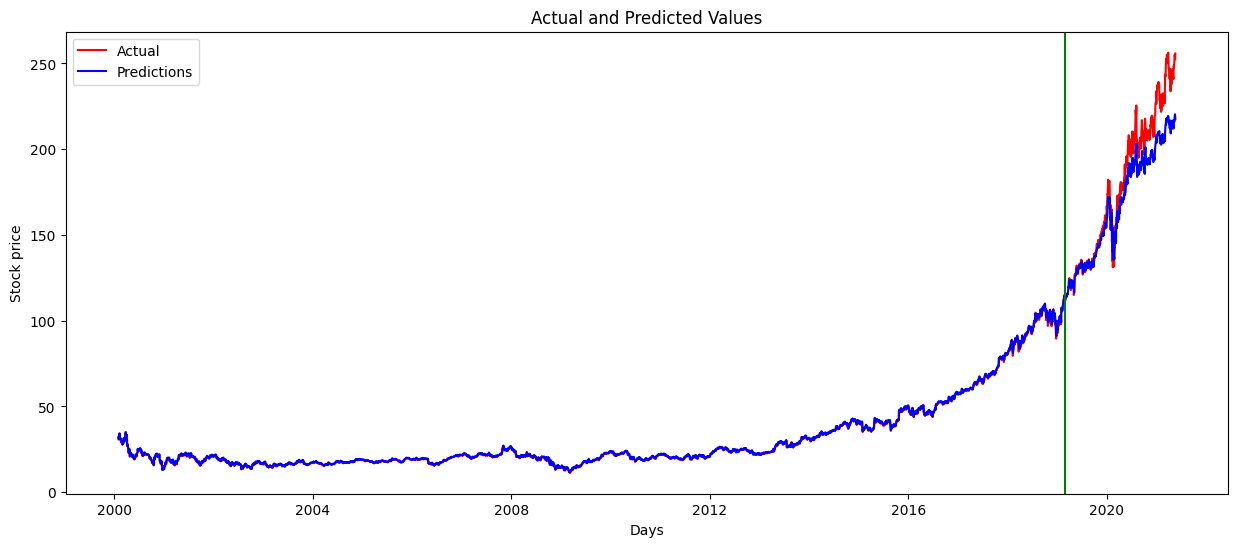

In [165]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_rnn1_unscaled, val_predict_rnn1_unscaled)

### Optimizers and learning rate scheduling

In [214]:
# experiment with optimizer and learning rate.
def RNN_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = None
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    elif optimizer == "RMSprop":
        optimizing_function = keras.optimizers.RMSprop()
    elif optimizer == "SGD":   
        optimizing_function = keras.optimizers.SGD() 

    model.compile(loss='mean_squared_error',optimizer=optimizing_function)
    return model


initial_learning_rate = 0.01
time_decay = initial_learning_rate / EPOCHS_NUM

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [215]:
'''
Running the vanilla RNN model with RMSProp,Adam, SGD and 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_vanilla = []

optimizers = ["Adam", "RMSprop", "SGD"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        
        model = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer=optimizer)
        
        fitted_model = None
        
        if i == 0:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)
        else:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                     batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[callbacks_decay[i - 1]])

        predict = fitted_model.model.predict(X_val)
        y_pred = scaler.inverse_transform(predict)
        y_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
        val_rmse = mean_squared_error(y_unscaled, y_pred, squared=False)

        results_vanilla.append((optimizer, callback_decay_keys[i], val_rmse))


Epoch 1/50
150/150 [==============================] - 4s 9ms/step - loss: 1.8182e-04 - val_loss: 0.0156
Epoch 2/50
150/150 [==============================] - 1s 7ms/step - loss: 2.9928e-05 - val_loss: 0.0092
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 1.5385e-05 - val_loss: 0.0058
Epoch 4/50
150/150 [==============================] - 1s 9ms/step - loss: 1.2809e-05 - val_loss: 0.0035
Epoch 5/50
150/150 [==============================] - 1s 7ms/step - loss: 9.8094e-06 - val_loss: 0.0039
Epoch 6/50
150/150 [==============================] - 1s 7ms/step - loss: 9.0301e-06 - val_loss: 0.0032
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0589e-05 - val_loss: 0.0030
Epoch 8/50
150/150 [==============================] - 1s 7ms/step - loss: 7.3603e-06 - val_loss: 0.0027
Epoch 9/50
150/150 [==============================] - 1s 9ms/step - loss: 9.2259e-06 - val_loss: 0.0031
Epoch 10/50
150/150 [==============================] - 1s 7ms/st

In [216]:
pd.DataFrame(results_vanilla, columns=[
                  "Optimizer", "Decay type", "Val RMSE"])

,Optimizer,Decay type,Val RMSE
0,Adam,constant,12.820397
1,Adam,step_decay,13.799592
2,Adam,exp_decay,13.782664
3,RMSprop,constant,14.854842
4,RMSprop,step_decay,90.308403
5,RMSprop,exp_decay,72.791378
6,SGD,constant,71.122586
7,SGD,step_decay,68.383710
8,SGD,exp_decay,56.066719


In [217]:
optimized_rnn = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")


fitted_optimized_rnn = optimized_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)


Epoch 1/50
150/150 [==============================] - 4s 10ms/step - loss: 1.2538e-04 - val_loss: 0.0100
Epoch 2/50
150/150 [==============================] - 1s 7ms/step - loss: 1.1837e-05 - val_loss: 0.0067
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0398e-05 - val_loss: 0.0048
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0310e-05 - val_loss: 0.0031
Epoch 5/50
150/150 [==============================] - 1s 7ms/step - loss: 8.2308e-06 - val_loss: 0.0031
Epoch 6/50
150/150 [==============================] - 1s 9ms/step - loss: 1.1122e-05 - val_loss: 0.0040
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 8.0280e-06 - val_loss: 0.0032
Epoch 8/50
150/150 [==============================] - 1s 7ms/step - loss: 8.8827e-06 - val_loss: 0.0023
Epoch 9/50
150/150 [==============================] - 1s 7ms/step - loss: 8.0355e-06 - val_loss: 0.0030
Epoch 10/50
150/150 [==============================] - 1s 7ms/s

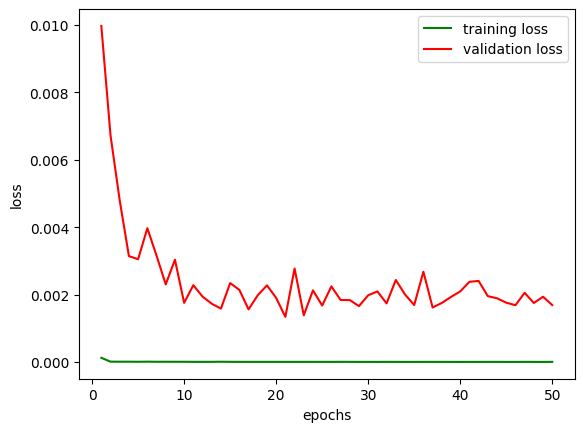

In [218]:
plot_training_history(fitted_optimized_rnn)

In [220]:
train_predict_optimized_rnn = fitted_optimized_rnn.model.predict(X_train)
val_predict_optimized_rnn = fitted_optimized_rnn.model.predict(X_val)


y_train_unscaled, train_predict_optimized_rnn_unscaled = print_error(y_train,train_predict_optimized_rnn,'Train')
y_val_unscaled, val_predict_optimized_rnn_unscaled = print_error(y_val,val_predict_optimized_rnn,'Validation')

19/19 [==============================] - 0s 5ms/step
Train root mean squared error (RMSE): 0.644
Validation root mean squared error (RMSE): 14.281


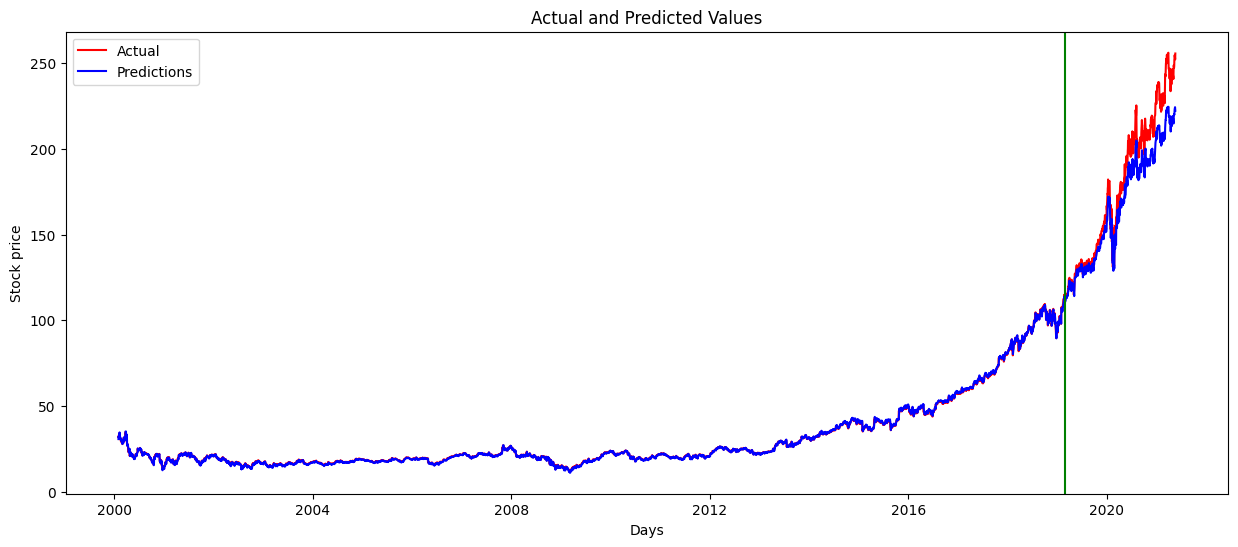

In [221]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_rnn_unscaled, val_predict_optimized_rnn_unscaled)

### LSTM

In [231]:
def vanilla_LSTM(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=False, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


In [232]:
n_hidden_units = 64
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [233]:

lstm_base = vanilla_LSTM(n_hidden_units, n_dense_units,input_shape, activation='tanh')

fitted_lstm_base = lstm_base.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)


Epoch 1/50
150/150 [==============================] - 9s 18ms/step - loss: 2.6860e-04 - val_loss: 0.0011
Epoch 2/50
150/150 [==============================] - 2s 15ms/step - loss: 1.0521e-05 - val_loss: 0.0013
Epoch 3/50
150/150 [==============================] - 2s 13ms/step - loss: 9.4038e-06 - val_loss: 0.0016
Epoch 4/50
150/150 [==============================] - 2s 15ms/step - loss: 1.0046e-05 - val_loss: 0.0013
Epoch 5/50
150/150 [==============================] - 2s 14ms/step - loss: 9.2294e-06 - val_loss: 0.0013
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 9.9832e-06 - val_loss: 0.0015
Epoch 7/50
150/150 [==============================] - 2s 15ms/step - loss: 9.5112e-06 - val_loss: 0.0016
Epoch 8/50
150/150 [==============================] - 2s 14ms/step - loss: 1.0602e-05 - val_loss: 0.0014
Epoch 9/50
150/150 [==============================] - 2s 16ms/step - loss: 8.8154e-06 - val_loss: 0.0015
Epoch 10/50
150/150 [==============================] - 

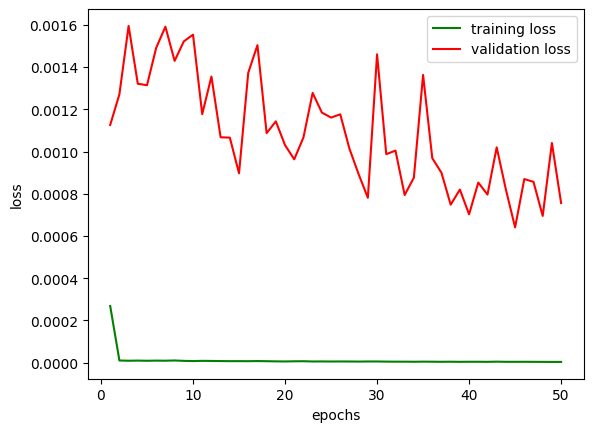

In [234]:
plot_training_history(fitted_lstm_base)


In [235]:
train_predict_lstm_base = fitted_lstm_base.model.predict(X_train)
val_predict_lstm_base = fitted_lstm_base.model.predict(X_val)

19/19 [==============================] - 0s 13ms/step


In [236]:
y_train_unscaled, train_predict_lstm_base = print_error(y_train,train_predict_lstm_base,'Train')
y_val_unscaled, val_predict_lstm_base_unscaled = print_error(y_val,val_predict_lstm_base,'Validation')

Train root mean squared error (RMSE): 0.719
Validation root mean squared error (RMSE): 9.553


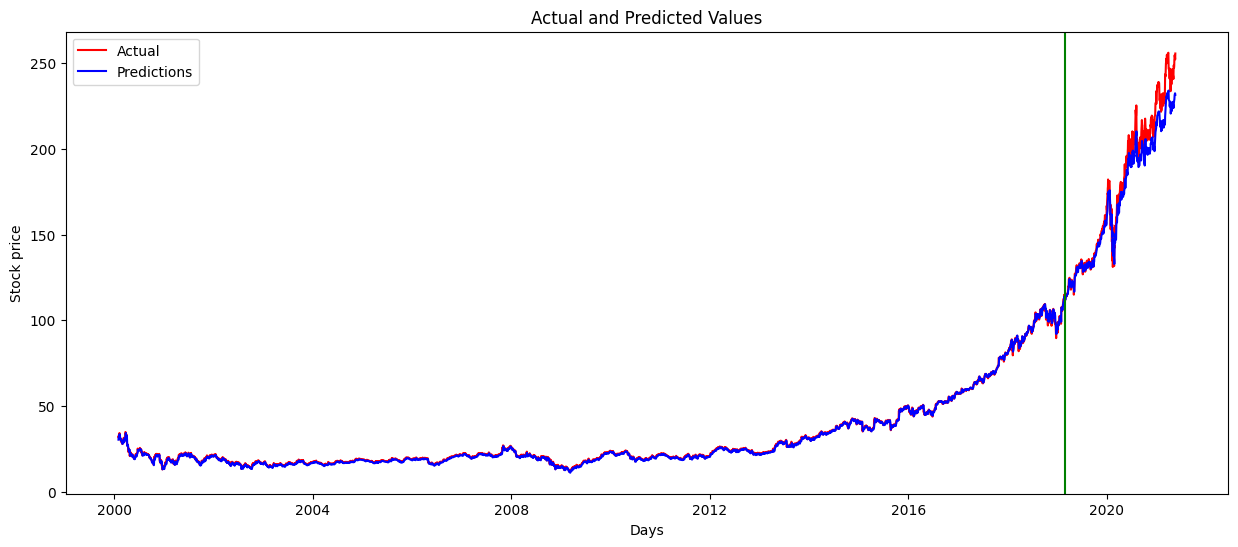

In [237]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_lstm_base, val_predict_lstm_base_unscaled)

### Add more layers

In [238]:
# Creating LSTM with multiple layers
def LSTM_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units_list[0], input_shape=input_shape,
                        activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [239]:
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [240]:
lstm_1 = LSTM_1(n_hidden_units_list, n_dense_units,input_shape, activation='tanh')

fitted_lstm_1 = lstm_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
150/150 [==============================] - 17s 52ms/step - loss: 1.8642e-04 - val_loss: 0.0032
Epoch 2/50
150/150 [==============================] - 6s 37ms/step - loss: 1.8662e-05 - val_loss: 0.0018
Epoch 3/50
150/150 [==============================] - 5s 36ms/step - loss: 1.9457e-05 - val_loss: 0.0017
Epoch 4/50
150/150 [==============================] - 5s 36ms/step - loss: 1.8834e-05 - val_loss: 0.0012
Epoch 5/50
150/150 [==============================] - 6s 37ms/step - loss: 1.6727e-05 - val_loss: 0.0019
Epoch 6/50
150/150 [==============================] - 5s 36ms/step - loss: 1.9491e-05 - val_loss: 0.0017
Epoch 7/50
150/150 [==============================] - 5s 36ms/step - loss: 1.3306e-05 - val_loss: 0.0018
Epoch 8/50
150/150 [==============================] - 6s 38ms/step - loss: 2.0041e-05 - val_loss: 0.0026
Epoch 9/50
150/150 [==============================] - 5s 36ms/step - loss: 1.4906e-05 - val_loss: 0.0023
Epoch 10/50
150/150 [==============================] -

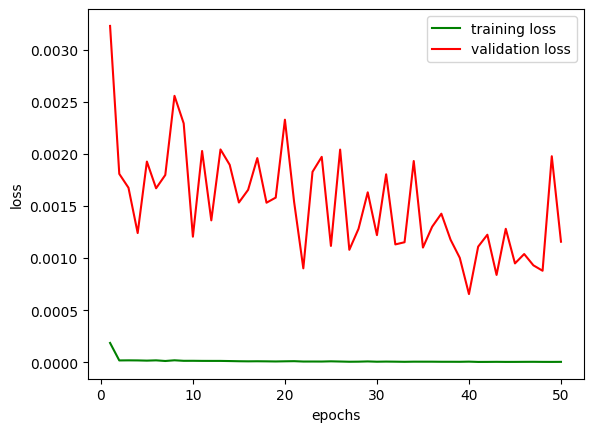

In [241]:
plot_training_history(fitted_lstm_1)

In [242]:
train_predict_lstm1 = fitted_lstm_1.model.predict(X_train)
val_predict_lstm1 = fitted_lstm_1.model.predict(X_val)

19/19 [==============================] - 0s 12ms/step


In [243]:
y_train_unscaled, train_predict_lstm1_unscaled = print_error(y_train,train_predict_lstm1,'Train')
y_val_unscaled, val_predict_lstm1_unscaled = print_error(y_val,val_predict_lstm1,'Validation')

Train root mean squared error (RMSE): 0.636
Validation root mean squared error (RMSE): 11.819


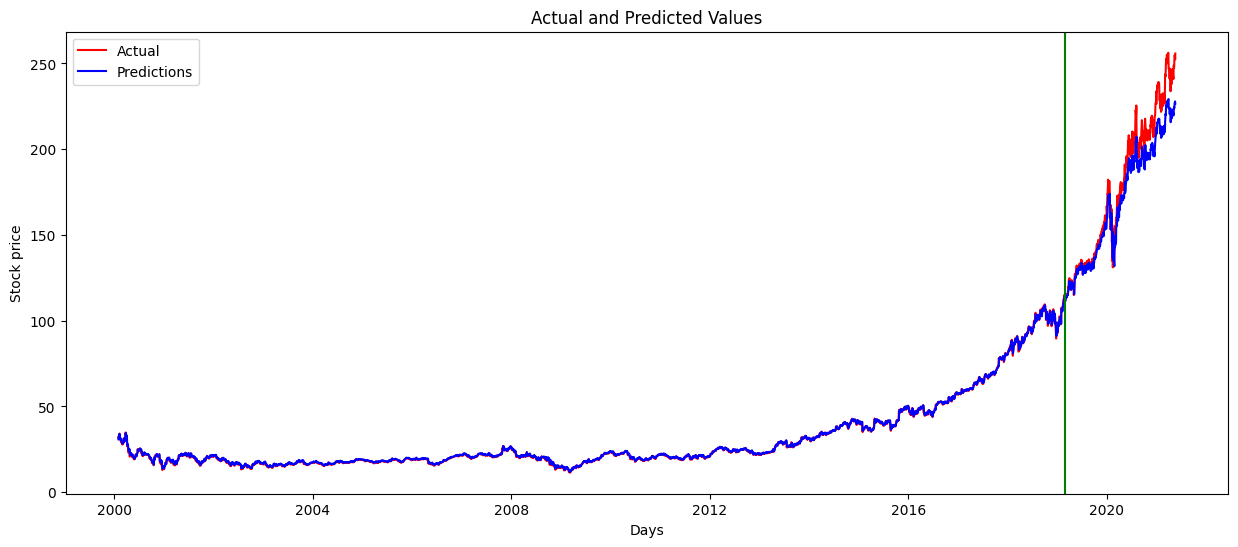

In [244]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_lstm1_unscaled, val_predict_lstm1_unscaled)


### Optimizers and learning rate scheduling

In [246]:
# experiment with optimizer and learning rate.
def LSTM_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = None
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    elif optimizer == "RMSprop":
        optimizing_function = keras.optimizers.RMSprop()
    elif optimizer == "SGD":   
        optimizing_function = keras.optimizers.SGD() 

    model.compile(loss='mean_squared_error',optimizer=optimizing_function)
    return model


In [247]:
'''
Running the vanilla LSTM model with RMSProp,Adam, SGD and 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_vanilla_lstm = []

optimizers = ["Adam", "RMSprop", "SGD"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        
        model = LSTM_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer=optimizer)
        
        fitted_model = None
        
        if i == 0:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)
        else:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                     batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[callbacks_decay[i - 1]])

        predict = fitted_model.model.predict(X_val)
        y_pred = scaler.inverse_transform(predict)
        y_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
        val_rmse = mean_squared_error(y_unscaled, y_pred, squared=False)

        results_vanilla_lstm.append((optimizer, callback_decay_keys[i], val_rmse))


Epoch 1/50
150/150 [==============================] - 4s 9ms/step - loss: 1.0472e-04 - val_loss: 0.0038
Epoch 2/50
150/150 [==============================] - 1s 7ms/step - loss: 8.3612e-06 - val_loss: 0.0020
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 7.9496e-06 - val_loss: 0.0014
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 5.6373e-06 - val_loss: 0.0015
Epoch 5/50
150/150 [==============================] - 1s 8ms/step - loss: 6.2652e-06 - val_loss: 0.0015
Epoch 6/50
150/150 [==============================] - 1s 7ms/step - loss: 5.6030e-06 - val_loss: 0.0010
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 5.4474e-06 - val_loss: 0.0015
Epoch 8/50
150/150 [==============================] - 1s 7ms/step - loss: 5.7949e-06 - val_loss: 0.0016
Epoch 9/50
150/150 [==============================] - 1s 7ms/step - loss: 5.2252e-06 - val_loss: 0.0013
Epoch 10/50
150/150 [==============================] - 1s 8ms/st

In [248]:
pd.DataFrame(results_vanilla_lstm, columns=["Optimizer", "Decay type", "Val RMSE"])

,Optimizer,Decay type,Val RMSE
0,Adam,constant,13.230772
1,Adam,step_decay,15.221871
2,Adam,exp_decay,16.302417
3,RMSprop,constant,15.298064
4,RMSprop,step_decay,68.198811
5,RMSprop,exp_decay,74.899452
6,SGD,constant,47.436511
7,SGD,step_decay,55.326365
8,SGD,exp_decay,62.912719


Choose the best

In [249]:
optimized_lstm = LSTM_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_lstm = optimized_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)


Epoch 1/50
150/150 [==============================] - 3s 9ms/step - loss: 6.2168e-04 - val_loss: 0.0320
Epoch 2/50
150/150 [==============================] - 1s 8ms/step - loss: 4.5369e-05 - val_loss: 0.0192
Epoch 3/50
150/150 [==============================] - 1s 9ms/step - loss: 3.1330e-05 - val_loss: 0.0120
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 2.5472e-05 - val_loss: 0.0085
Epoch 5/50
150/150 [==============================] - 1s 8ms/step - loss: 2.0759e-05 - val_loss: 0.0062
Epoch 6/50
150/150 [==============================] - 1s 8ms/step - loss: 1.8761e-05 - val_loss: 0.0058
Epoch 7/50
150/150 [==============================] - 1s 9ms/step - loss: 1.7838e-05 - val_loss: 0.0058
Epoch 8/50
150/150 [==============================] - 1s 7ms/step - loss: 1.5616e-05 - val_loss: 0.0038
Epoch 9/50
150/150 [==============================] - 1s 7ms/step - loss: 1.5220e-05 - val_loss: 0.0044
Epoch 10/50
150/150 [==============================] - 1s 7ms/st

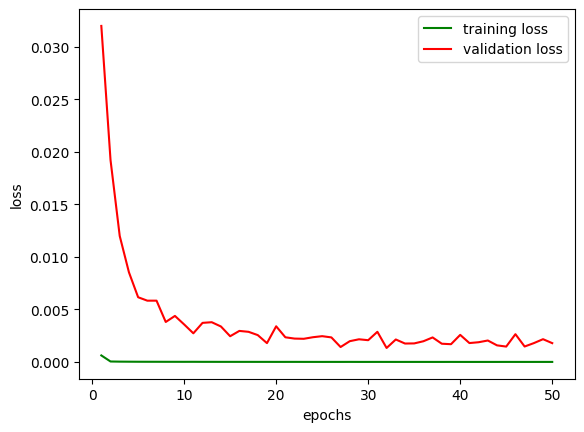

In [250]:
plot_training_history(fitted_optimized_lstm)

In [251]:
train_predict_optimized_lstm = fitted_optimized_lstm.model.predict(X_train)
val_predict_optimized_lstm = fitted_optimized_lstm.model.predict(X_val)


19/19 [==============================] - 0s 5ms/step


In [252]:
y_train_unscaled, train_predict_optimized_lstm_unscaled = print_error(y_train,train_predict_optimized_lstm,'Train')
y_val_unscaled, val_predict_optimized_lstm_unscaled = print_error(y_val,val_predict_optimized_lstm,'Validation')


Train root mean squared error (RMSE): 0.833
Validation root mean squared error (RMSE): 14.7


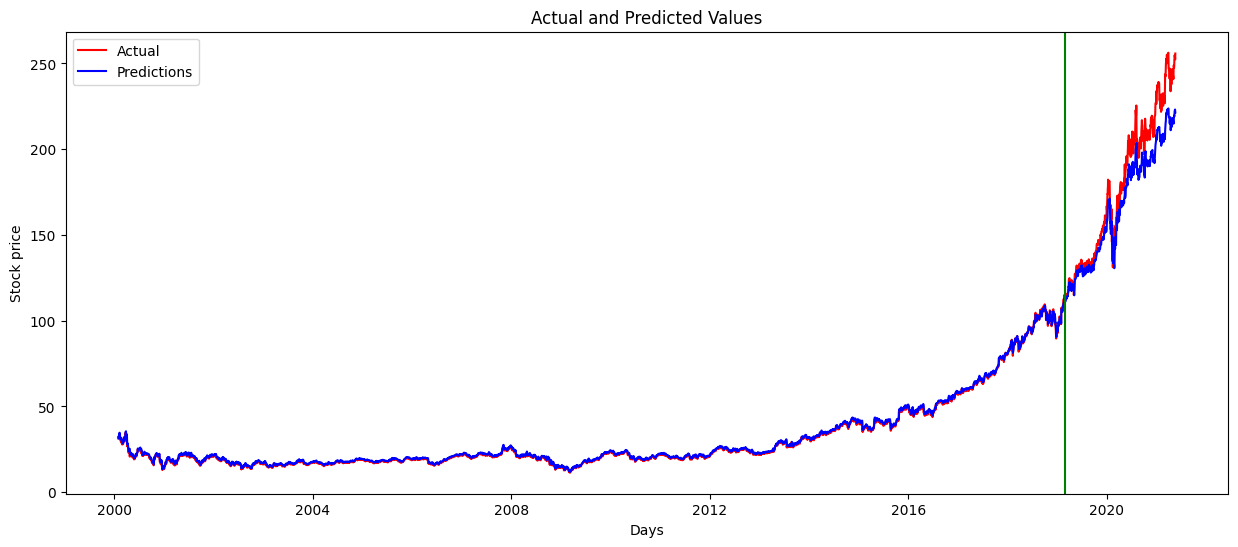

In [253]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_lstm_unscaled, val_predict_optimized_lstm_unscaled)